# STARDIS

In [1]:
# Useful for development

%load_ext autoreload
%autoreload 2

In [2]:
# Import necessary code

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from tardis.io.atom_data import AtomData

from astropy import units as u, constants as const

from stardis.io import read_marcs_to_fv
from stardis.plasma import create_stellar_plasma
from stardis.opacities import calc_alphas
from stardis.transport import raytrace

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

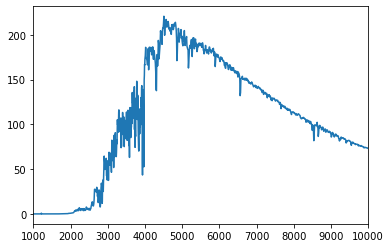

In [3]:
# Load and plot actual sun spectrum

sun_spec = pd.read_csv('data/solar_data/NewGuey2003.txt', skiprows=20, delim_whitespace=True, names=['wave', 'flux'])
sun_spec['wave'] *= 10
sun_spec['flux'] = u.Quantity(sun_spec['flux'].to_numpy(), "W/(m2 nm)").to("erg/(s cm2 AA)").value
plt.plot(sun_spec.wave, sun_spec.flux)
plt.xlim(1000, 10000);

In [4]:
# Load atomic data and create the stellar model

adata = AtomData.from_hdf('kurucz_cd23_chianti_H_He.h5')
stellar_model = read_marcs_to_fv('data/marcs/sun.mod', adata, 30)
adata.prepare_atom_data(stellar_model.abundances.index.tolist())

In [5]:
# Define wavelengths and frequencies to be used for ray tracing

tracing_lambdas = np.arange(1000, 10000, 1) * u.Angstrom
tracing_nus = tracing_lambdas.to(u.Hz, u.spectral())

In [6]:
# Create the stellar plasma

stellar_plasma = create_stellar_plasma(stellar_model, adata)

In [7]:
# Calculate opacities

alphas = calc_alphas(
    stellar_plasma,
    stellar_model,
    tracing_nus,
    wbr_fpath="data/wishart_broad_reinhardt_cross_section.dat",
)

In [8]:
# Perform ray tracing

I_nu = raytrace(stellar_model, alphas, tracing_nus)

In [9]:
# Determine spectra

I_lambda = I_nu[55] * tracing_nus/tracing_lambdas

# R_sun/r_sun-to-earth = 0.00458
intensity_to_flux = np.pi * 0.00458**2

F_lambda = intensity_to_flux * I_lambda

smooth_F_lambda = ndimage.gaussian_filter1d(F_lambda, 5)

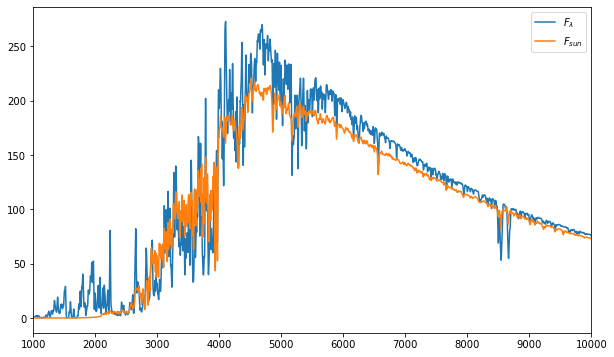

In [10]:
# Plot spectra

#%matplotlib notebook

plt.figure(figsize=(10,6))
plt.plot(tracing_lambdas, smooth_F_lambda, label="$F_\lambda$")
plt.plot(sun_spec.wave, sun_spec.flux, label="$F_{sun}$")

plt.xlim((1000,10000))
plt.legend();